In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
import sktime

from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import (
    EnsembleForecaster,
    MultiplexForecaster,
    TransformedTargetForecaster,
    make_reduction,
)
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import (
    ExpandingWindowSplitter,
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.performance_metrics.forecasting import  MeanAbsolutePercentageError, MeanSquaredError
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.utils.plotting import plot_series
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.tbats import TBATS
smape = MeanAbsolutePercentageError(symmetric = True)
rmse  = MeanSquaredError(square_root=True)

from sklearn.ensemble import RandomForestRegressor

from sklearn.pipeline import make_pipeline

from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier



r2_score = lambda y_pred, y_test: 1-np.sum(np.square(y_pred - y_test))/np.sum(np.square(y_test - np.mean(y_test)))

%matplotlib inline

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm

from sktime.utils.plotting import plot_series
from sktime.forecasting.sarimax import SARIMAX
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split

from sktime.performance_metrics.forecasting import  MeanAbsolutePercentageError, MeanSquaredError
smape = MeanAbsolutePercentageError(symmetric = True)
rmse  = MeanSquaredError(square_root=True)
r2_score = lambda y_pred, y_test: 1-np.sum(np.square(y_pred - y_test))/np.sum(np.square(y_test - np.mean(y_test)))


In [3]:
sns.set_style('white')
sns.set(rc={'figure.figsize':(23, 4)})

Load our dataset

In [4]:
df = pd.read_csv('all_messages_cnt.csv',
    sep='\t',
    encoding='utf-8',
    parse_dates=['datetime'],
    index_col='datetime')

df.head(5)

,txt_cnt
datetime,
2022-10-13 08:00:00+00:00,4
2022-10-13 09:00:00+00:00,7
2022-10-13 10:00:00+00:00,0
2022-10-13 11:00:00+00:00,0
2022-10-13 12:00:00+00:00,0


Visualize timeline

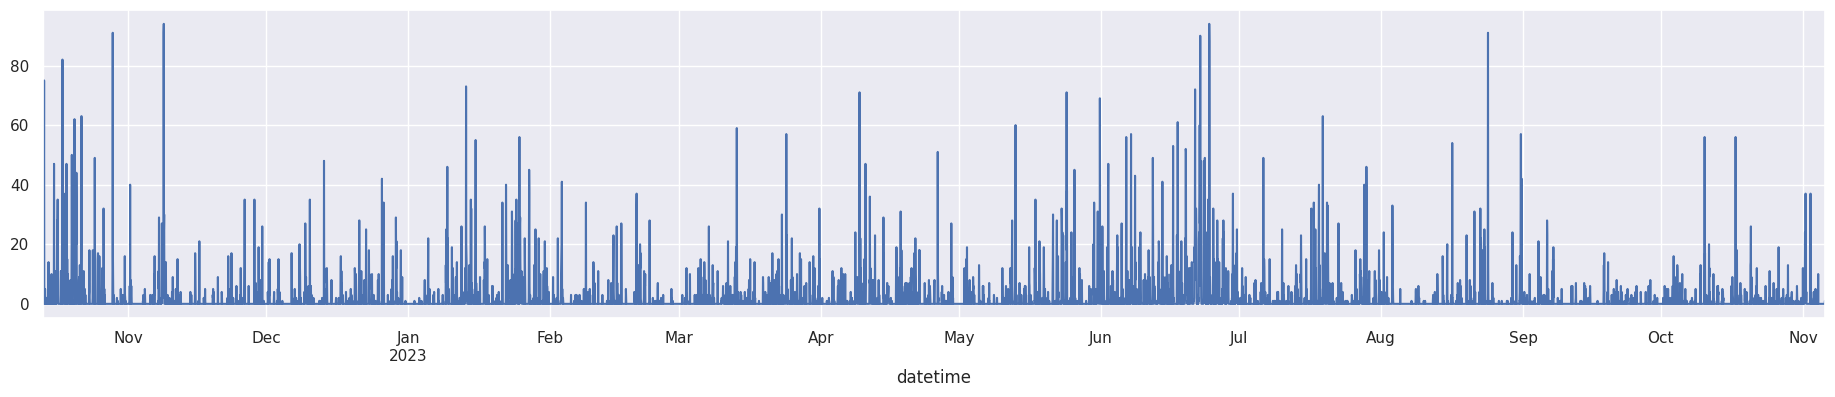

In [5]:

df['txt_cnt'].plot();

Search trend

<Axes: xlabel='datetime'>

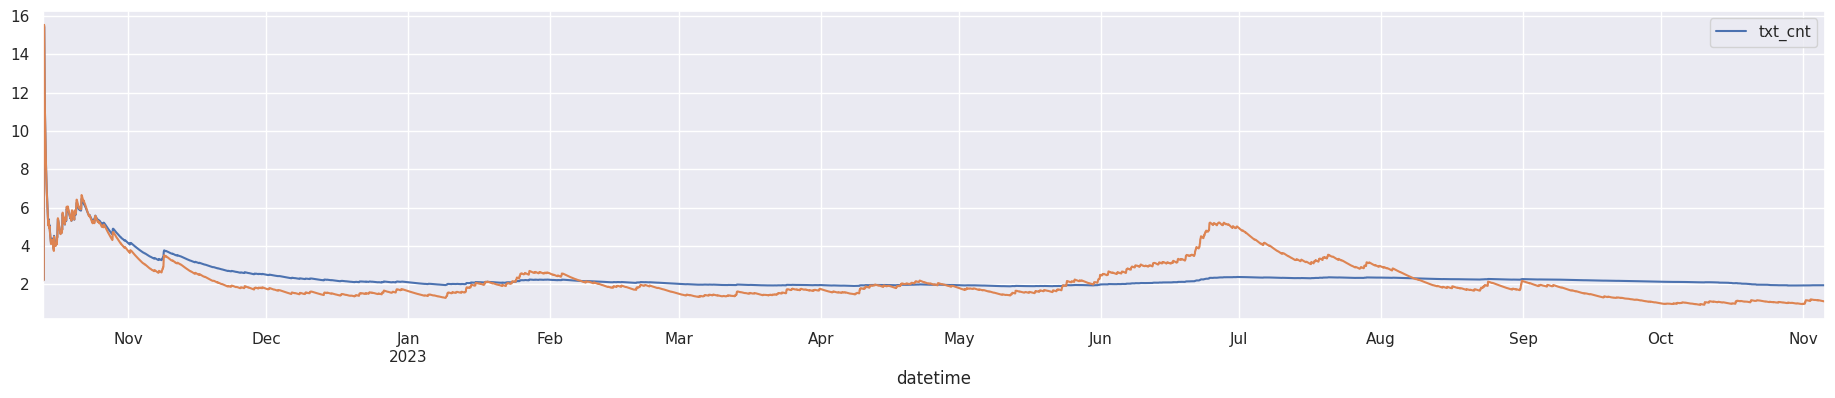

In [6]:
df[['txt_cnt']].rolling('365d').mean().plot( linewidth=1.5,);
df.txt_cnt.ewm(halflife=365, min_periods=0, adjust=True).mean().plot()

In [7]:
y = df.txt_cnt#.asfreq('1h')

Check splitted data size: Train: 6248, Test: 3076


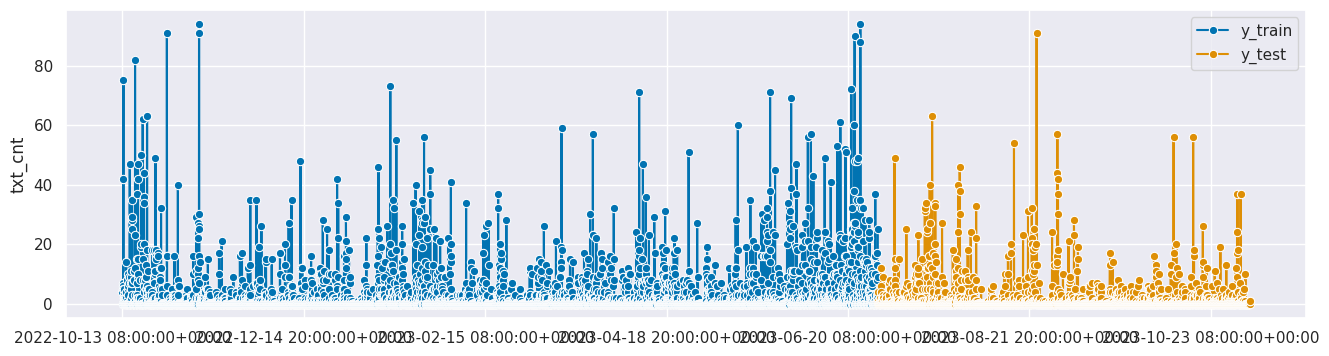

In [8]:
TEST_SIZE = int(0.33 * y.size)

y_train, y_test = temporal_train_test_split(y, test_size=TEST_SIZE)

print(f'Check splitted data size: Train: {y_train.shape[0]}, Test: {y_test.shape[0]}')

sktime.utils.plotting.plot_series(y_train, y_test, labels=["y_train", "y_test"]);

In [9]:
fh = ForecastingHorizon(y_test.index, is_relative=False)

/home/test/.local/lib/python3.11/site-packages/sktime/forecasting/base/_fh.py:862: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  return x.to_period(freq)
/home/test/.local/lib/python3.11/site-packages/sktime/forecasting/base/_fh.py:862: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  return x.to_period(freq)
/home/test/.local/lib/python3.11/site-packages/sktime/forecasting/base/_fh.py:862: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  return x.to_period(freq)


sMAPE = 1.639


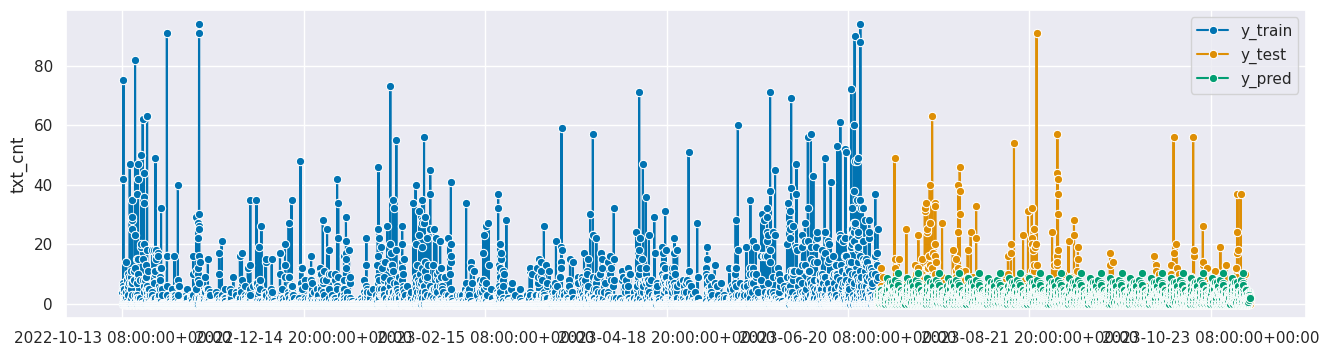

In [10]:
SEASON = 24*7

forecaster = NaiveForecaster(strategy="mean", sp=SEASON)
forecaster.fit(y_train)

y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

/home/test/.local/lib/python3.11/site-packages/sktime/forecasting/base/_fh.py:862: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  return x.to_period(freq)
/home/test/.local/lib/python3.11/site-packages/sktime/forecasting/base/_fh.py:862: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  return x.to_period(freq)
/home/test/.local/lib/python3.11/site-packages/sktime/forecasting/base/_fh.py:862: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  return x.to_period(freq)
/home/test/.local/lib/python3.11/site-packages/sktime/forecasting/base/_fh.py:862: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  return x.to_period(freq)


sMAPE = 0.793


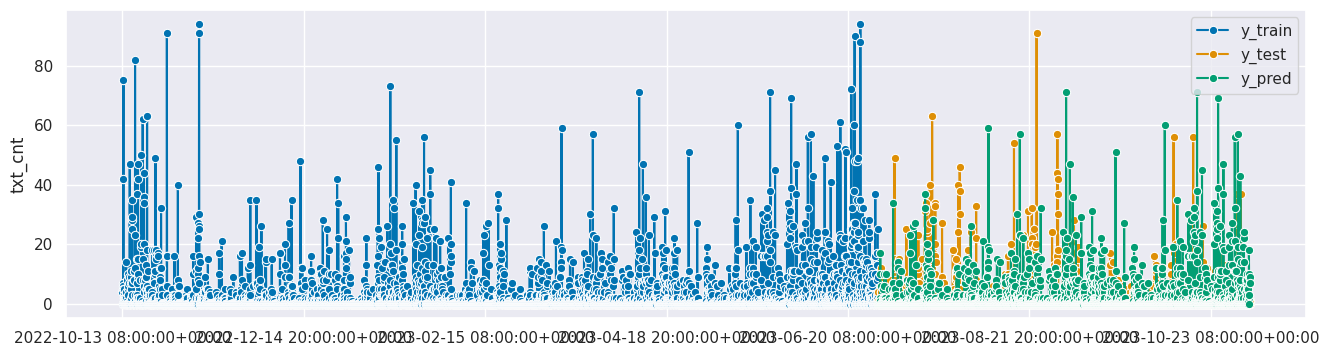

In [12]:
from sklearn.neighbors import KNeighborsRegressor

REGRESSION_WINDOW = 24*7

regressor  = KNeighborsRegressor(n_neighbors=1)
forecaster = make_reduction(regressor, window_length=REGRESSION_WINDOW, strategy="recursive")

forecaster.fit(y_train)

y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

In [174]:
import pickle

In [175]:
pickle.dump(forecaster, open('model.pkl', 'wb'))

In [196]:
fh = ForecastingHorizon(np.arange(1, 25))

In [201]:
y_pred = np.array(forecaster.predict(fh))
y_pred

array([0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])